**Importing Libraries and Dataset**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

In [3]:
def rgb_gray(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray_img

**Loading Coloured (RGB) Image Dataset**

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
print(x_train.shape)
print(x_test.shape)
img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


**Converting RGB to Greyscale images for Autocolourisation**

In [6]:
x_train_Gray = []
x_test_Gray = []


for i in range(x_train.shape[0]):
  img = x_train[i]
  x_train_Gray.append(rgb_gray(img))

for i in range(x_test.shape[0]):
  img = x_test[i]
  x_test_Gray.append(rgb_gray(img))

In [7]:
print(len(x_train_Gray))
print(len(x_test_Gray))

50000
10000


In [8]:
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255

In [9]:
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim, img_dim, 1)

In [11]:
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

**Encoder Model using CNN**

In [13]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)

In [14]:
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(lat_dim, name='latent_vector')(x)

Creating ENCODER Model

In [15]:
encoder = Model(inputs, latent, name='encoder_model')

In [16]:
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
___________________________________________

**Decoder Model using CNN**

In [17]:
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [18]:
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

In [19]:
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

Creating DECODER Model

In [20]:
decoder = Model(latent_inputs, outputs, name = 'decoder_model')

In [21]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)       

**AUTOENCODER MODEL**

In [22]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [23]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 256)               1418496   
_________________________________________________________________
decoder_model (Functional)   (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


**Pre-Training Processing**

In [24]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)

In [25]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [26]:
print(filepath)

/content/saved_models/colorized_ae_model.h5


In [27]:
checkpoints = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True)

In [29]:
callbacks = [lr_reducer, checkpoints]

**TRAINING**

In [30]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [31]:
autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 30, batch_size = 32, callbacks = callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.4838
Epoch 00001: val_loss improved from inf to 0.01079, saving model to /content/saved_models/colorized_ae_model.h5
1563/1563 [==============================] - 722s 462ms/step - loss: 0.0159 - accuracy: 0.4838 - val_loss: 0.0108 - val_accuracy: 0.5167
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.5047
Epoch 00002: val_loss improved from 0.01079 to 0.00925, saving model to /content/saved_models/colorized_ae_model.h5
1563/1563 [==============================] - 722s 462ms/step - loss: 0.0100 - accuracy: 0.5047 - val_loss: 0.0093 - val_accuracy: 0.5286
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.5120
Epoch 00003: val_loss improved from 0.00925 to 0.00863, saving model to /content/saved_models/colorized_ae_model.h5
1563/1563 [==============================] - 758s 485ms/step - loss: 0.0089 - accuracy: 

In [37]:
x_decoded = autoencoder.predict(x_test_Gray)

In [38]:
autoencoder.save('colourization_model.h5')

In [39]:
from google.colab import files
files.download('colourization_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reults Output**

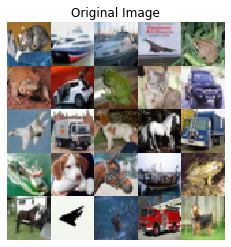

In [40]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

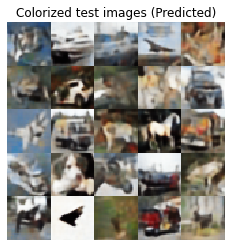

In [41]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()